# Pre training on an unlabeled Data

In [20]:
from importlib.metadata import version

pkgs = ["matplotlib", 
        "numpy", 
        "tiktoken", 
        "torch",
        "tensorflow"
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")
    
import torch.nn as nn 
import torch

matplotlib version: 3.5.3
numpy version: 1.26.3
tiktoken version: 0.9.0
torch version: 2.5.1
tensorflow version: 2.15.0


We will implement the training loop and code the bsaic model evaluation to pretrain an LLM 

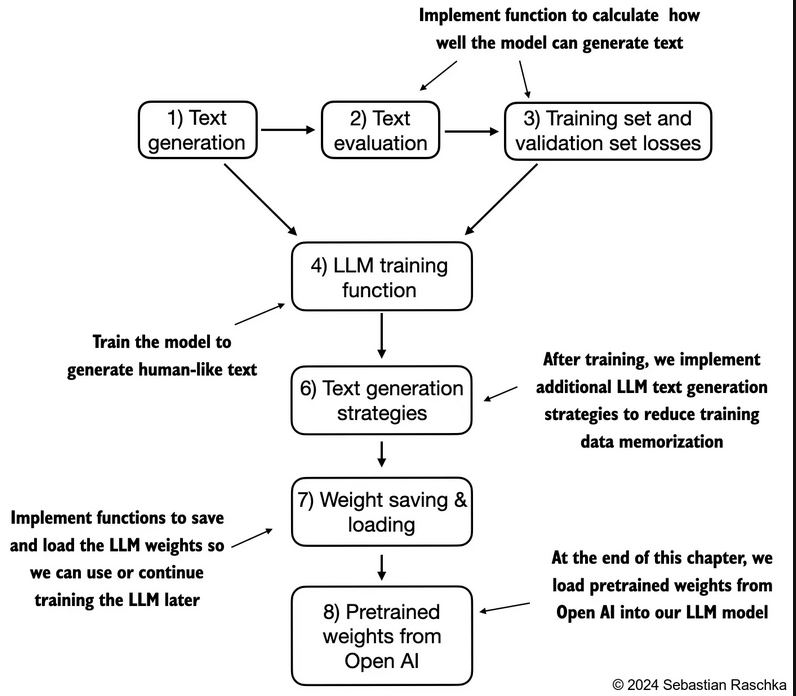

## Evaluating generative text models

### build the GPT model file from llm_architecture

In [21]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,                # Vocabulary size
    "context_length": 256,             # Context length - shortened
    "emb_dim": 768 ,                    # Embedding dimension
    "n_heads": 12 ,                     # Number of attention heads 
    "n_layers": 12,                     # Number of layers 
    "dropout": 0.1 ,                    # Dropout Rate 
    "qkv_bias": False                   # Query-Key-Value bias
}

In [22]:
class MultiHeadAttention(nn.Module):
    
    def __init__(self , d_in , d_out , context_length , dropout , num_heads , qkv_bias = False):
        super().__init__()
        
        assert(d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"
            
        self.d_out = d_out 
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads 
        
        self.W_query = nn.Linear(d_in , d_out , bias = qkv_bias)
        self.W_key = nn.Linear(d_in , d_out , bias = qkv_bias)
        self.W_value = nn.Linear(d_in , d_out , bias = qkv_bias)
        
        self.dropout = nn.Dropout(dropout)
        self.out_proj = nn.Linear(d_out , d_out)
        self.register_buffer(
            "mask" , 
            torch.triu(torch.ones(context_length , context_length), diagonal=1)
        )
        
    def forward(self , x): 
        
        b , num_token , d_in = x.shape
        
        keys = self.W_key(x) # shape = b , num_token , d_out
        values = self.W_value(x)
        queries = self.W_query(x)
        
        # split the above matrices into 4-D Byh adding in num_heads into the dimentions 
        
        keys = keys.view(b , num_token , self.num_heads , self.head_dim )
        values = values.view(b , num_token , self.num_heads , self.head_dim )
        queries = queries.view(b , num_token , self.num_heads , self.head_dim )
        
        # transpose - b , num_token , self.num_heads , self.head_dim ---> b , self.num_heads , num_token , self.head_dim
        
        keys = keys.transpose(1,2)
        values = values.transpose(1,2)
        queries = queries.transpose(1,2)
        
        # Compute scaled dot product attemtion 
        
        atten_score = queries @ keys.transpose(2,3) # b , self.num_heads , num_token , num_token
        
        # Use mask to only look at attention for the tokens seen 
        
        mask_bool = self.mask.bool()[:num_token , :num_token]
        
        # use the mask 
        atten_score.masked_fill_(mask_bool, -torch.inf)
        
        # calculate attention wieghts 
        
        atten_weights = torch.softmax(atten_score/keys.shape[-1] ** 0.5 , dim = -1) # b , self.num_heads , num_token , num_token
        
        atten_weights = self.dropout(atten_weights)
        
        context_vec = atten_weights @ values  # b , self.num_heads , num_token , self.head_dim
        
        context_vec = context_vec.transpose(1,2) # b , num_token  , self.num_heads , self.head_dim
        
        # combine heads 
        context_vec = context_vec.contiguous().view(b , num_token , self.d_out) # b , num_token  , self.d_out
        context_vec = self.out_proj(context_vec)
        
        return context_vec

In [23]:
class LayerNorm(nn.Module):
    def __init__(self,emb_dim):
        
        super().__init__()
        
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
        
    def forward(self , x): 
        mean = x.mean(dim = -1 , keepdim = True)
        variance = x.var(dim = -1 , keepdim = True , unbiased = False) # bessles correction using (n-1) instead of n for variance denominator
        
        norm_x = (x-mean) / torch.sqrt(variance + self.eps) # eps is to avoid division by zero error
        
        return self.scale * norm_x + self.shift # Scale and shift and two traininable parameters. 
    
    
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))
        
  
class FeedForward(nn.Module):
    
    def __init__(self , cfg): 
        
        super().__init__()
        self.layers = nn.Sequential(
                nn.Linear(cfg['emb_dim'] , 4 * cfg['emb_dim']),                    # first linear layer (EXPANSION)
                GELU(),                                                     # GELU Activation Layer 
                nn.Linear(4 * cfg['emb_dim'] ,cfg['emb_dim']),          # Second linear layer (CONTRACTION)
            ) 
        
        
    def forward(self , x): 
        return self.layers(x)

In [24]:
    
class TransformerBlock(nn.Module): 
    
    def __init__(self , cfg): 
        
        super().__init__()
        
        self.att = MultiHeadAttention(
            d_in = cfg['emb_dim'],
            d_out = cfg['emb_dim'],
            context_length = cfg['context_length'],
            dropout = cfg['dropout'],
            num_heads = cfg['n_heads'],
            qkv_bias = cfg['qkv_bias']  
        )
        
        self.ff = FeedForward(cfg)
        
        self.norm1 = LayerNorm(cfg['emb_dim'])
        
        self.norm2 = LayerNorm(cfg['emb_dim'])
        
        self.dropout_shortcut = nn.Dropout(cfg['dropout'])
        
        
    def forward(self , x): 
        
        # Shortcut connection for the attention block 
        shortcut  = x 
        
        x = self.norm1(x)
        x = self.att(x)
        x = self.dropout_shortcut(x)
        x = x + shortcut
        
        # shortcut connection for feedforward 
        shortcut = x 
        
        x = self.norm2(x)
        x = self.ff(x)
        x = self.dropout_shortcut(x)
        
        x = x + shortcut
        
        return x  

In [25]:
class GPTModel(nn.Module): 
    
    def __init__(self , cfg): 
        
        super().__init__()
        
        self.token_emb = nn.Embedding(cfg['vocab_size'] , cfg['emb_dim'])
        self.positional_emb = nn.Embedding(cfg['context_length'] , cfg['emb_dim'])
        
        self.drop_emb = nn.Dropout(cfg['dropout'])
        
        self.transformer_block = nn.Sequential(
            
            *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])]
            
        )
        
        self.final_norm = LayerNorm(cfg['emb_dim'])
        
        self.out_head = nn.Linear(
            cfg['emb_dim'] , cfg['vocab_size'] , bias = False
        )
        
        
    def forward(self , in_indx): 
        
        batch_size , seq_len = in_indx.shape
        
        token_embeddings = self.token_emb(in_indx)
        position_embeddings = self.positional_emb(torch.arange(seq_len, device = in_indx.device))
        
        x = token_embeddings + position_embeddings
        x= self.drop_emb(x)
        
        x = self.transformer_block(x)
        x = self.final_norm(x)
        
        logits = self.out_head(x)
        
        return logits
        
        

In [26]:
torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)

In [27]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)
        
        # Get the last one per batch
        # (batch, n_tokens, vocab_size) ---> (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax 
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append result index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)
        
        #repeat

    return idx

### We define some more decoding and encoding functions
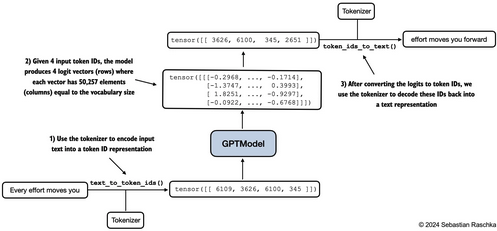

In [28]:
import tiktoken

tokenizer = tiktoken.get_encoding('gpt2')

def text_to_token_ids(text , tokenizer):
    
    encoded = tokenizer.encode(text , allowed_special = {'<|endoftext|>'})
    
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # Add batch dimension
    
    return encoded_tensor

def token_ids_to_text(token_ids , tokenizer):
    decoded = tokenizer.decode(token_ids.squeeze(0).tolist())
    
    return decoded

In [29]:
text1 = 'Get over here '

encoded = text_to_token_ids(text1 , tokenizer)
print(encoded)

decoded = token_ids_to_text(encoded , tokenizer)

print(decoded)

tensor([[3855,  625,  994,  220]])
Get over here 


### lets run the prediction for a text with untrained model. 

In [30]:
text2 = 'Every effort moves you'

token_ids_pred = generate_text_simple(model, idx = text_to_token_ids(text2,tokenizer), max_new_tokens = 6, context_size = GPT_CONFIG_124M['context_length']  )

print(f'Predicted token ids \n {token_ids_pred}')

text2_generated = token_ids_to_text(token_ids_pred,tokenizer)

print(f'Predicted text: \n {text2_generated}')

Predicted token ids 
 tensor([[ 6109,  3626,  6100,   345, 43663, 11497, 24784, 28084, 33973, 24912]])
Predicted text: 
 Every effort moves you Samoa parad Defensive MacBook Referospace


This output is garbage.. But HOW MUCH GARBAGE ? 

## Lets try to define some loss function

In [31]:
input1 = 'every effort moves'
input2 = 'I really like'

output1 = ' effort moves you'
output2 = ' really like chocolate'

input = torch.stack([text_to_token_ids(input1,tokenizer)[0],text_to_token_ids(input2,tokenizer)[0]] )
print(input)

output = torch.stack([text_to_token_ids(output1,tokenizer)[0],text_to_token_ids(output2,tokenizer)[0]] )
print(output)

tensor([[16833,  3626,  6100],
        [   40,  1107,   588]])
tensor([[ 3626,  6100,   345],
        [ 1107,   588, 11311]])


In [32]:
with torch.no_grad():
    logits = model(input)
    
probas = torch.softmax(logits , dim = -1)

print(probas)

print(probas.shape)

tensor([[[1.7742e-05, 1.3650e-05, 9.7857e-06,  ..., 2.5622e-05,
          4.8043e-06, 2.2105e-05],
         [7.8708e-06, 1.5493e-05, 8.0773e-06,  ..., 3.8312e-05,
          6.6745e-06, 1.6972e-05],
         [3.0539e-05, 1.2569e-05, 2.2474e-05,  ..., 3.0583e-05,
          1.1685e-05, 1.5281e-05]],

        [[1.0566e-05, 1.1744e-05, 1.4698e-05,  ..., 1.0140e-05,
          4.9747e-05, 1.6912e-05],
         [8.2014e-06, 2.3240e-05, 1.1935e-05,  ..., 2.9623e-05,
          9.0974e-06, 1.6575e-05],
         [2.0103e-05, 3.2759e-05, 3.2745e-05,  ..., 6.1181e-06,
          6.1257e-05, 1.6406e-05]]])
torch.Size([2, 3, 50257])


In [33]:
token_ids_pred = torch.argmax(probas , dim = -1 , keepdim=True)

print(f'Predicted token: \n {token_ids_pred}')

predicted_text_1 = token_ids_to_text(token_ids_pred[0].flatten() , tokenizer)
print(f'Expected Text Batch 1: {output1}')
print(f'Predicted Text Batch 1: {predicted_text_1}')


predicted_text_2 = token_ids_to_text(token_ids_pred[1].flatten() , tokenizer)
print(f'Expected Text Batch 2: {output2}')
print(f'Predicted Text Batch 2: {predicted_text_2}')

Predicted token: 
 tensor([[[16657],
         [47747],
         [42826]],

        [[49906],
         [13294],
         [41751]]])
Expected Text Batch 1:  effort moves you
Predicted Text Batch 1:  Armed onlookNetflix
Expected Text Batch 2:  really like chocolate
Predicted Text Batch 2:  pressuring futfaith


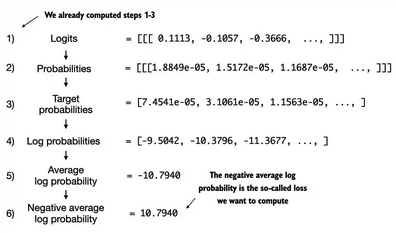

In [34]:
#step - 3:  Get target probabilities

text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], output[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], output[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([8.8260e-05, 2.8307e-05, 1.1124e-05])
Text 2: tensor([1.1908e-05, 5.6366e-05, 4.4133e-06])


In [35]:
# step - 4: Get log of the probabilities

log_probas = torch.log(torch.cat((target_probas_1,target_probas_2)))
print(log_probas)

tensor([ -9.3352, -10.4724, -11.4064, -11.3383,  -9.7836, -12.3309])


In [36]:
# step - 5: Average log probability
avg_log_prob = torch.mean(log_probas)
print(avg_log_prob)

tensor(-10.7778)


In [37]:
# step - 6: Negative of the log likelihood

nll = -1 * avg_log_prob
print(nll)

tensor(10.7778)


### we can also do this using nn.torch.cross_entropy

In [38]:
# Logits have shape (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets have shape (batch_size, num_tokens)
print("Output shape:", output.shape)


logits_flat = logits.flatten(0,1)
output_flat = output.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", output_flat.shape)


Logits shape: torch.Size([2, 3, 50257])
Output shape: torch.Size([2, 3])
Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [39]:
loss = torch.nn.functional.cross_entropy(logits_flat , output_flat)

print(loss)

tensor(10.7778)


## Perplexity loss:

Another measure of loss 

Measure how well the probability distribution predicted by the model matches the actual distribution of words in the dataset. 

More interpretable way of understanding model uncertainity in predicting the next token. 

lower perplexity = better 

perplexity = e ^ loss 

In [40]:
perplexity = torch.exp(loss)
print(f'Perplexity loss = {perplexity}')

Perplexity loss = 47945.1953125


Interpretation: Model is roughly as uncertain as if it had to choose the next token randomly from about 47945 tokens in the vocabulary (highly interpretable)

## Calculating the training and validation set losses

In [41]:
with open('../../data/the-verdict.txt', "r", encoding="utf-8") as file:
    text_data = file.read()

In [42]:
text_data[:99]

'I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no '

In [43]:
print(f'Total characters : {len(text_data)}')

print(f'Total tokens: {len(tokenizer.encode(text_data ))}')

Total characters : 20479
Total tokens: 5145


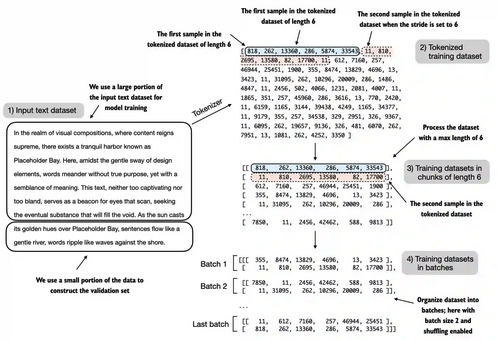

Lets code the dataloader now 

In [44]:
from torch.utils.data import Dataset , DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self , text , tokenizer , max_length, stride):
        
        self.input_ids = []
        self.target_ids = []
        
        # tokenize the input
        
        token_ids = tokenizer.encode(text , allowed_special={'<|endoftext|>'})
        
        #use sliding window to break the text into overlapping sequence of max_length
        
        for i in range(0,len(token_ids)-max_length , stride):
            input = token_ids[i:i + max_length]
            target = token_ids[i+1: i+1+max_length]
            
            self.input_ids.append(torch.tensor(input)) 
            self.target_ids.append(torch.tensor(target))
            
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, index):
        return self.input_ids[index] , self.target_ids[index]
    

def create_dataloader_v1(text , batch_size = 4 , max_length = 256 , stride = 128 , shuffle = True , drop_last = True , num_workers = 0):
    
    #Initilaize the tokenizer
    tokenizer = tiktoken.get_encoding('gpt2')
    
    # create dataset
    dataset = GPTDatasetV1(text = text, tokenizer = tokenizer , max_length = max_length, stride = stride)
    
    #create dataloader
    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=shuffle, 
        drop_last=drop_last, 
        num_workers=num_workers
    )
    
    return dataloader
    

In [45]:
# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)


In [46]:
# Sanity check

if len(tokenizer.encode(text_data)) * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if len(tokenizer.encode(text_data)) * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

In [47]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [48]:

train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)



Training tokens: 4608
Validation tokens: 512
All tokens: 5120


### create a helper function to do the loss calculations

In [49]:
def calc_loss_batch(input_batch , target_batch , model , device):
    input_batch , target_batch = input_batch.to(device) , target_batch.to(device)
    
    #generate the logits
    logits = model(input_batch)
    
    #calculate the loss 
    loss = torch.nn.functional.cross_entropy(logits.flatten(0,1), target_batch.flatten())
    return loss 

def calc_loss_loader(data_loader , model , device , num_batches = None): 
    
    total_loss = 0. 
    
    if len(data_loader) == 0: 
        return float("nan")
    elif num_batches is None: 
        num_batches = len(data_loader)
    else: 
        num_batches = min(num_batches,len(data_loader))
        
    for i , (input_batch,target_batch) in enumerate(data_loader):
        if i < num_batches: 
            loss = calc_loss_batch(input_batch , target_batch , model , device)
            total_loss += loss.item()
            
        else: 
            break
    
    return total_loss / num_batches

### lets calculate the loss 

In [50]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using {device} device.")

Using mps device.


In [51]:
model.to(device)

torch.manual_seed(123)

with torch.no_grad(): 
    train_loss = calc_loss_loader(train_loader , model , device )
    
    val_loss = calc_loss_loader(val_loader , model , device )
    
print(f'Training loss: {train_loss}')
print(f'Validation loss: {val_loss}')

Training loss: 10.989404466417101
Validation loss: 10.981025695800781


## Training an LLM

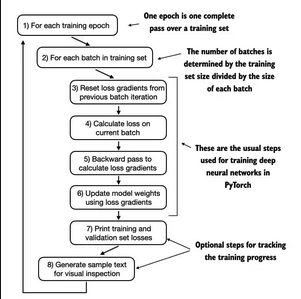

In [52]:
def evaluate_model(model , train_loader , val_loader , device , eval_iter):
    model.eval()
    
    with torch.no_grad(): 
        train_loss = calc_loss_loader(train_loader , model , device , num_batches=eval_iter)
    
        val_loss = calc_loss_loader(val_loader , model , device, num_batches=eval_iter )
        
    model.train()
    
    return train_loss , val_loss


def generate_and_print_sample(model , tokenizer , device , start_context): 
    model.eval()
    context_size = model.positional_emb.weight.shape[0]
    
    encoded = text_to_token_ids(start_context , tokenizer).to(device)
    
    with torch.no_grad():
        token_ids = generate_text_simple(
            model, idx = encoded, max_new_tokens = 50, context_size= context_size
        )
    
    decoded_text = token_ids_to_text(token_ids , tokenizer)  
    
    print(decoded_text.replace("\n", " ")) # compact print format 
    
    model.train()  



def train_model_simple(model , train_loader , val_loader , optimizer , device , num_epochs , eval_freq , eval_iter , start_context , tokenizer): 
    
    # initialize the lists to track the loses and tokens seen
    
    train_losses , val_losses , track_token_seen = [] , [] , []
    
    tokens_seen , global_step = 0 , -1
    
    # main training loop 
    for epoch in range(num_epochs): 
        
        model.train()
        
        for input_batch , target_batch in train_loader: 
            
            #step 3 - reset the loss gradient from previous epoch
            optimizer.zero_grad()
            
            #step 4 - Ccaluclate loss 
            loss = calc_loss_batch(input_batch , target_batch , model , device)
            
            #step 5 - Backward pass the loss
            loss.backward()
            
            #step 6 - Update the model weights using loss gradient
            optimizer.step()
            
            #step 7 - Print training and validation set losses 
            
            tokens_seen += input_batch.numel()
            global_step += 1
            
            # optimal evaluation step 
            if global_step % eval_freq ==0:
                train_loss , val_loss = evaluate_model(
                    model , train_loader , val_loader , device , eval_iter
                )
                
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_token_seen.append(tokens_seen)
                
                print(f'Epoch {epoch + 1} (Step {global_step:06d}):'
                      f'Train Loss: {train_loss:.3f}, Val Loss {val_loss:.3f} '
                      )
                
        # print a sample output for every epoh 
        generate_and_print_sample(
            model , tokenizer , device , start_context
        )
        
    return train_losses , val_losses , track_token_seen

## Lets train xD

In [84]:
import time 

start_time = time.time()

torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)

model.to(device)

optimizer = torch.optim.AdamW(model.parameters() , lr = 0.0004 , weight_decay= 0.1)

num_epochs = 10 

train_losses , val_losses , track_token_seen = train_model_simple(model , train_loader , val_loader , optimizer , device , num_epochs , eval_freq = 5 , eval_iter = 5 , start_context = 'Every effort moves you' , tokenizer = tokenizer)

end_time = time.time()
execution_time_minutes = (end_time-start_time) / 60

print(f'Training completed in {execution_time_minutes:.2f} minutes')

Epoch 1 (Step 000000):Train Loss: 9.931, Val Loss 10.039 
Epoch 1 (Step 000005):Train Loss: 8.168, Val Loss 8.443 
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Epoch 2 (Step 000010):Train Loss: 6.621, Val Loss 7.075 
Epoch 2 (Step 000015):Train Loss: 6.039, Val Loss 6.623 
Every effort moves you, the,, and,,,,,,,,,,,,,,,,,,,,,,,, the,,,,,,,,,,,,,, and,,,,,
Epoch 3 (Step 000020):Train Loss: 5.564, Val Loss 6.521 
Epoch 3 (Step 000025):Train Loss: 5.514, Val Loss 6.423 
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and
Epoch 4 (Step 000030):Train Loss: 5.154, Val Loss 6.367 
Epoch 4 (Step 000035):Train Loss: 5.004, Val Loss 6.332 
Every effort moves you, and a, and a, and a a, and a, and a, and, and, and a, and, and to the picture, and a was, and a was, and, and, and a, and, and a
Epoch 5 (Step 000040):Train Loss: 4.347, Val Loss 6.235 
Every effort moves you know

Looks like it has overfitted 

## Lets create the train and val loss 

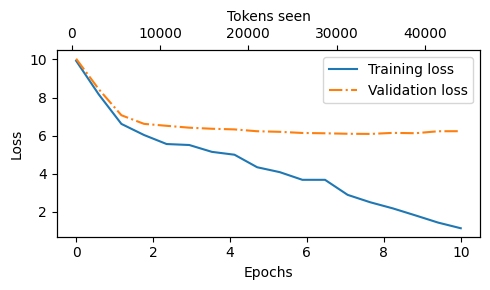

In [86]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, track_token_seen, train_losses, val_losses)

## Decoding strategies to control randomness

In [87]:
model.to("cpu")
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the fact with the last word.










Everytime i run this.. it always gives the same output. We need to generate text with a lot of variety (greedy decoding)

In [88]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

inverse_vocab = {v: k for k, v in vocab.items()}

# Suppose input is "every effort moves you", and the LLM
# returns the following logits for the next token:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)

print(probas)

next_token_id = torch.argmax(probas).item()

print(next_token_id)

# The next generated token is then as follows:
print(inverse_vocab[next_token_id])

tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
        1.0120e-04, 3.5758e-01, 4.0122e-03])
3
forward


Instead of using argmax everytime - we can use multinomial function. And the multinomial function will sample the next token from the probability distribution

In [91]:


torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(next_token_id)
print(inverse_vocab[next_token_id])



3
forward


Lets do a sampling and see if forward is chossen all the time ?

In [92]:
def print_sampled_tokens(probas):
    torch.manual_seed(123) 
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample), minlength=len(probas))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)


73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward
0 x you


This adds variety! and doesnt always return forward

WHats temperature ?
"Temperature scaling" is just a fancy word for dividing the logits by a number greater than 1

with greter than 1 will result in more uniformly distributed  
with less than 1 we will get for sharper and peaky distribution 

In [93]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# Temperature values
temperatures = [1, 0.1, 5]  # Original, higher confidence, and lower confidence

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]



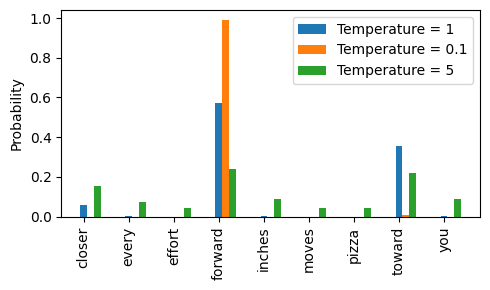

In [94]:
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

In [95]:
print_sampled_tokens(scaled_probas[1])

0 x closer
0 x every
0 x effort
985 x forward
0 x inches
0 x moves
0 x pizza
15 x toward
0 x you


In [97]:
print_sampled_tokens(scaled_probas[2]) # Some output will will be nonsensicle

165 x closer
75 x every
42 x effort
239 x forward
71 x inches
46 x moves
32 x pizza
227 x toward
103 x you


## Top - K scaling

to be able to use higher temperatures to increase output diversity and to reduce the probability of nonsensical sentences, we can restrict the sampled tokens to the top-k most likely tokens:

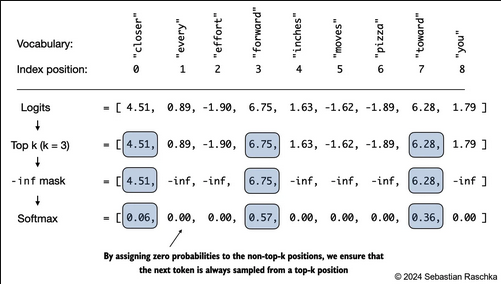

In [98]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [99]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")), 
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [100]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


## Lets update the text generation function

In [61]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        #Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx



In [102]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves youlit to work up surprise. Th--I felt that event by his"


## Loading and saving model weights in PyTorch

In [103]:
torch.save(model.state_dict(), "model.pth")

In [104]:
model = GPTModel(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("model.pth", map_location=device, weights_only=True))
model.eval();

In [105]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    }, 
    "model_and_optimizer.pth"
)


In [53]:
checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

## Loading pretrained weights from OpenAI

In [8]:
!pip install tensorflow tqdm

In [9]:
print("TensorFlow version:", version("tensorflow"))
print("tqdm version:", version("tqdm"))

TensorFlow version: 2.15.0
tqdm version: 4.64.0


In [12]:
from gpt_download3 import download_and_load_gpt2

In [13]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

/Users/sprabhu/.local/share/virtualenvs/GitHub-sKygbMQR/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 33.1kiB/s]
/Users/sprabhu/.local/share/virtualenvs/GitHub-sKygbMQR/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 4.53MiB/s]
/Users/sprabhu/.local/share/virtualenvs/GitHub-sKygbMQR/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: I

In [16]:
print("Settings:", settings)

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}


In [18]:
print("Parameter dictionary keys:", params.keys())

Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [19]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


In [54]:
# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval();

In [56]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [ ]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.positional_emb.weight = assign(gpt.positional_emb.weight, params['wpe'])
    gpt.token_emb.weight = assign(gpt.token_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.transformer_block[b].att.W_query.weight = assign(
            gpt.transformer_block[b].att.W_query.weight, q_w.T)
        gpt.transformer_block[b].att.W_key.weight = assign(
            gpt.transformer_block[b].att.W_key.weight, k_w.T)
        gpt.transformer_block[b].att.W_value.weight = assign(
            gpt.transformer_block[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.transformer_block[b].att.W_query.bias = assign(
            gpt.transformer_block[b].att.W_query.bias, q_b)
        gpt.transformer_block[b].att.W_key.bias = assign(
            gpt.transformer_block[b].att.W_key.bias, k_b)
        gpt.transformer_block[b].att.W_value.bias = assign(
            gpt.transformer_block[b].att.W_value.bias, v_b)

        gpt.transformer_block[b].att.out_proj.weight = assign(
            gpt.transformer_block[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.transformer_block[b].att.out_proj.bias = assign(
            gpt.transformer_block[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.transformer_block[b].ff.layers[0].weight = assign(
            gpt.transformer_block[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.transformer_block[b].ff.layers[0].bias = assign(
            gpt.transformer_block[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.transformer_block[b].ff.layers[2].weight = assign(
            gpt.transformer_block[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.transformer_block[b].ff.layers[2].bias = assign(
            gpt.transformer_block[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.transformer_block[b].norm1.scale = assign(
            gpt.transformer_block[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.transformer_block[b].norm1.shift = assign(
            gpt.transformer_block[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.transformer_block[b].norm2.scale = assign(
            gpt.transformer_block[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.transformer_block[b].norm2.shift = assign(
            gpt.transformer_block[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])
    



In [63]:
    
load_weights_into_gpt(gpt, params)
gpt.to(device);

In [72]:


torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=50,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=2.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))



Output text:
 Every effort moves you toward more efficient and higher priority use over one of many types the other could support while making those that get more likely to follow and use that strategy the first time - you aren "on point." The primary goal being "trying on whatever" your
